In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [112]:
df = pd.read_csv("fatal-police-shootings-data.csv")

In [113]:
df.head()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,-123.122,47.247,True
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,-122.892,45.487,True
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False,-97.281,37.695,True
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False,-122.422,37.763,True
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False,-104.692,40.384,True


In [114]:
# first name and last name
df['first_name'] = df['name'].apply(lambda x: x.split()[0] if isinstance(x, str) else None)
df['last_name'] = df['name'].apply(lambda x: x.split()[-1] if isinstance(x, str) else None)

In [115]:
# add month and year
df['date'] = df['date'].apply(lambda x: pd.to_datetime(x))
df['month'] = df['date'].apply(lambda x: x.month)
df['year'] = df['date'].apply(lambda x: x.year)

In [116]:
df.head()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,...,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact,first_name,last_name,month,year
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,...,attack,Not fleeing,False,-123.122,47.247,True,Tim,Elliot,1,2015
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,...,attack,Not fleeing,False,-122.892,45.487,True,Lewis,Lembke,1,2015
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,...,other,Not fleeing,False,-97.281,37.695,True,John,Quintero,1,2015
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,...,attack,Not fleeing,False,-122.422,37.763,True,Matthew,Hoffman,1,2015
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,...,attack,Not fleeing,False,-104.692,40.384,True,Michael,Rodriguez,1,2015


In [111]:
df[df.year == 2015].month.value_counts()

Jul    104
Aug     94
Mar     92
Dec     88
Apr     84
Oct     84
Sep     82
Feb     77
Nov     77
Jan     76
May     71
Jun     65
Name: month, dtype: int64

In [120]:
len(df[df.year == 2015 & df.month == 1])

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [119]:
sorted(df[df.year == 2015].month.value_counts())

[65, 71, 76, 77, 77, 82, 84, 84, 88, 92, 94, 104]

ValueError: shape mismatch: objects cannot be broadcast to a single shape

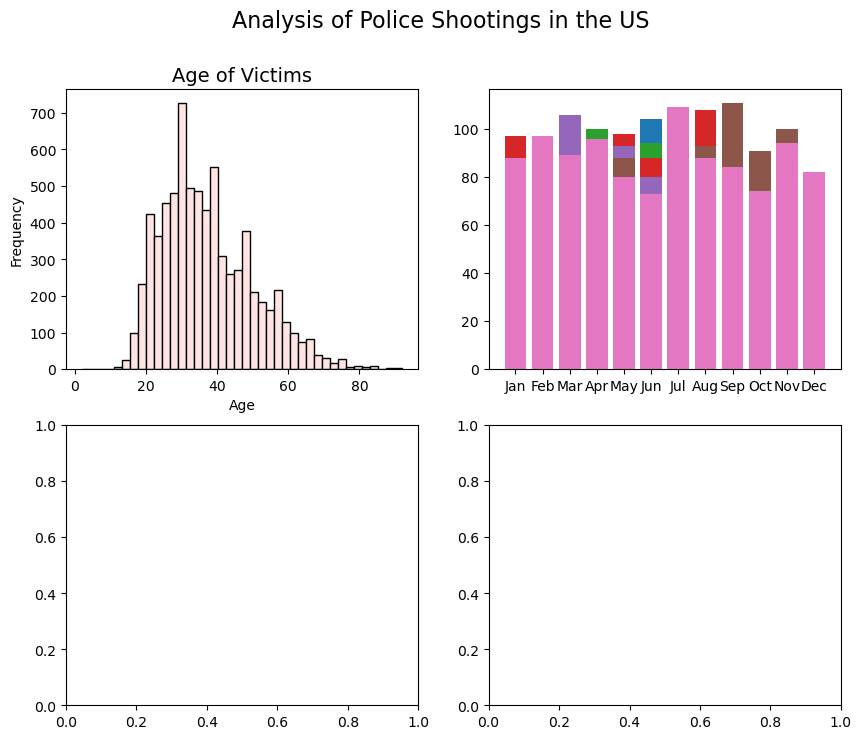

In [108]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle("Analysis of Police Shootings in the US", fontsize = 16)

# histogram plot
ax1.hist(
    x = df['age'],
    bins = 40,
    color = 'mistyrose',
    ec = 'black'
)
ax1.set_title("Age of Victims", fontsize = 14)
ax1.set_xlabel("Age")
ax1.set_ylabel("Frequency")

# stacked bar plot of dates
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for year in sorted(df['year'].unique()):
    ax2.bar(
        x = months,
        height = df[df.year == year].groupby('month')['id'].count(),
        label = year
    )
ax2.set_title("Shootings by Date", fontsize = 14)
ax2.set_xlabel("Date")
ax2.set_ylabel("Frequency")

fig.tight_layout()
fig.show()

AxesSubplot(0.547727,0.53;0.352273x0.35)


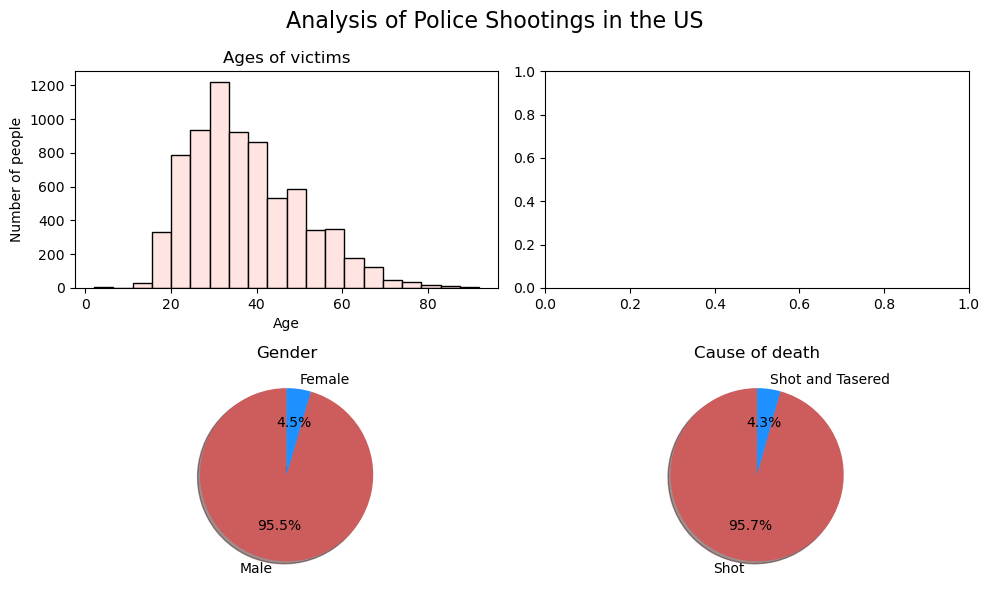

In [65]:
plt.figure(figsize=(10, 6))
plt.suptitle("Analysis of Police Shootings in the US", fontsize=16)

# histogram plot
plt.subplot(2, 2, 1)
plt.hist(
    x = df['age'],
    bins = 20,
    color = 'mistyrose',
    ec = 'black'
)
plt.title("Ages of victims")
plt.xlabel("Age")
plt.ylabel("Number of people")

# plot stacked bar chart of number of deaths each month over the years
fig, ax = plt.subplot(2, 2, 2)

# months as labels
labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# number of deaths in january in 2015
jan_2015 = df[(df['month'] == 1) & (df['year'] == 2015)].shape[0]

# pie chart of gender
plt.subplot(2, 2, 3)
gender = df['gender'].value_counts()
plt.title("Gender")
plt.pie(
    x = gender,
    labels = [ "Male", "Female" ],
    autopct = "%1.1f%%",
    shadow = True,
    startangle = 90,
    colors = [ "indianred", "dodgerblue" ]
)

# pie chart of manner of death
plt.subplot(2, 2, 4)
manner_of_death = df['manner_of_death'].value_counts()
plt.title("Cause of death")
plt.pie(
    x = manner_of_death,
    labels = [ "Shot", "Shot and Tasered" ],
    autopct = "%1.1f%%",
    shadow = True,
    startangle = 90,
    colors = [ "indianred", "dodgerblue" ]
)

plt.tight_layout()
plt.show()

In [64]:
pd.to_datetime(df['date'])[0].

2015

TypeError: cannot unpack non-iterable AxesSubplot object

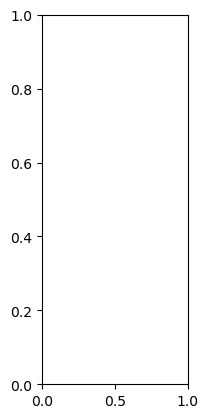

In [69]:
labels = ['G1', 'G2', 'G3', 'G4', 'G5']
men_means = [20, 35, 30, 35, 27]
women_means = [25, 32, 34, 20, 25]
men_std = [2, 3, 4, 1, 2]
women_std = [3, 5, 2, 3, 3]
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplot(1,3,2)

ax.bar(labels, men_means, width, yerr=men_std, label='Men')
ax.bar(labels, women_means, width, yerr=women_std, bottom=men_means,
       label='Women')

ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.legend()

plt.show()